# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.losses = np.zeros(max_iter) 
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        #по формуле
        mmm = (X * weights).sum(axis=1)
        return 1 / (1 + math.e ** (-mmm))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        LL = 0
        for i in range(len(y)):
            LL += np.log(1 + math.e**(-y[i]*(weights[0]+(weights[1:]*x[i]).sum())))
        LL = LL/len(y) + 1/(2*self.C)*np.linalg.norm(weights)
        return LL
    
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        for i in range(self.max_iter):
            delta = np.zeros(num_features)
            for j in range(len(y)):
                sm = self.weights_ @ X_ext[j]
                delta += y[j]*X_ext[j,:]*(1-1/(1+np.exp(-sm*y[j])))/len(y)
            delta -= (1/self.C)*self.weights_
            delta = -delta
#           print("Номер итерации: " + str(i) + " разница: " + str(np.linalg.norm(self.eta*delta)))
#           print(delta)
            self.weights_ -= self.eta * delta
            self.losses[i] = self.get_loss(X, self.weights_, y)
            if np.linalg.norm(self.eta*delta)<self.tol:
#                 print('Стоп итераций на ' + str(i))
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        ww = self.predict_proba(X)
        pre = []
        for i in range(len(ww)):
            if ww[i] >= 0.5:
                pre.append(1)
            else:
                pre.append(-1)
        return pre

In [5]:
from sklearn import datasets
from sklearn import metrics

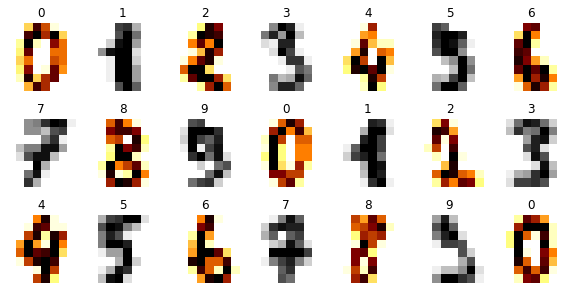

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
lr_clf.weights_


array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


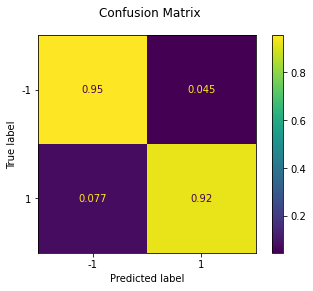

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [18]:
## your code

Последний коэффициент потерь для i = 1000

In [19]:
model.get_loss(X_train, model.weights_, y_train)

0.3890801566794996

График коээфициента потерь в зависимости от количества итераций подбора параметров весов

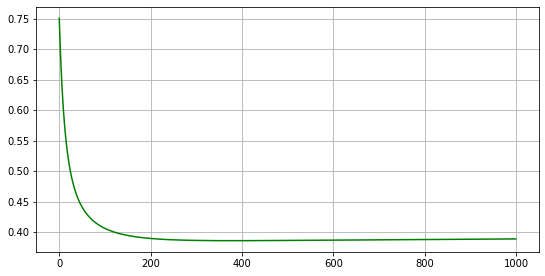

In [20]:
plt.figure(figsize=(9, 4.5))
plt.plot(model.losses, c='green', label='L1')
plt.grid(True)


**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [21]:
## your code

eta: float, default=0.001
                Learning rate.

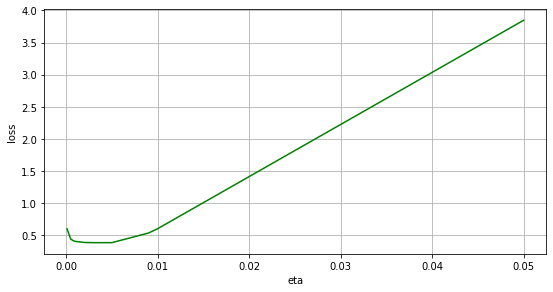

In [22]:
losses = []
etas = [0.0001, 0.0005, 0.0008, 0.001, 0.002, 0.003, 0.004, 0.005, 0.009, 0.01, 0.05]
for i in range(len(etas)):
    eta = etas[i]
    model = CustomLogisticRegression(max_iter=100, eta = eta)
    model.fit(X_train, y_train)
    losses.append(model.get_loss(X_train, model.weights_, y_train))
plt.figure(figsize=(9, 4.5))
plt.plot(etas, losses, c='green', label='L1')
plt.xlabel('eta')
plt.ylabel('loss')
plt.grid(True)    

< your thoughts > Для используемых данных значение функции Logistic Loss уменьшается при уменьшении коэффициента Learning rate eta. Модель подбирает более чувствительные коэффициенты, но скорость падает, поэтому возможно потребуется большее количество итераций подбора.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [23]:
## your code

C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.

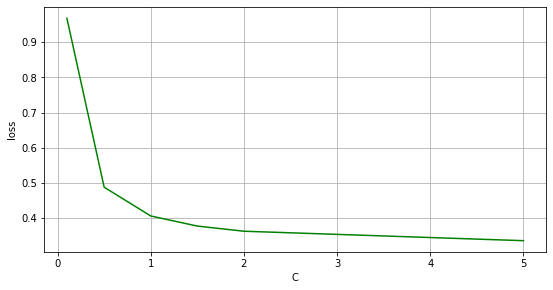

In [24]:
losses = []
Cs = [0.1, 0.5, 1.0, 1.5, 2, 5]
for i in range(len(Cs)):
    C = Cs[i]
    model = CustomLogisticRegression(max_iter=100, C = C)
    model.fit(X_train, y_train)
    losses.append(model.get_loss(X_train, model.weights_, y_train))
plt.figure(figsize=(9, 4.5))
plt.plot(Cs, losses, c='green', label='L1')
plt.xlabel('C')
plt.ylabel('loss')
plt.grid(True)   

< your thoughts >Для используемых данных значение функции Logistic Loss уменьшается при увеличении коэффициента регуляризации C

**(0.5 points)** Compare zero initialization and random initialization. 

In [25]:
## your code

zero_init: bool, default=False
                Zero weight initialization.

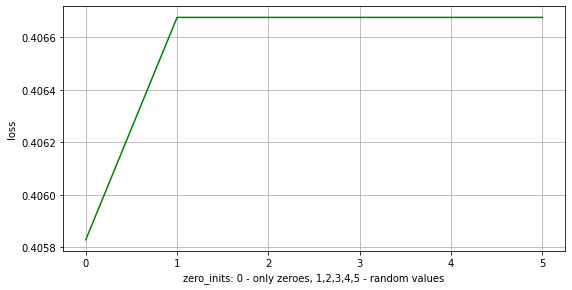

In [26]:
losses = []
zero_inits = [0, 1, 2, 3, 4, 5]
for i in range(len(zero_inits)):
    if zero_inits[i] > 0:
        zero_init = False
    else:
        zero_init = True
    model = CustomLogisticRegression(max_iter=100, zero_init=zero_init)
    model.fit(X_train, y_train)
    losses.append(model.get_loss(X_train, model.weights_, y_train))
plt.figure(figsize=(9, 4.5))
plt.plot(zero_inits, losses, c='green', label='L1')
plt.xlabel('zero_inits: 0 - only zeroes, 1,2,3,4,5 - random values')
plt.ylabel('loss')
plt.grid(True)   

< your thoughts >Для используемых данных вариант модели с начальными нулевыми коэффициентами значение функции Logistic Loss меньше, чем при использовании случайных начальных значений

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [27]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        res = np.zeros([len(X), len(Y)])
        for i in range(len(X)):
            for j in range(res.shape[1]):
                res[i,j] = np.linalg.norm(X[i] - Y[j])
        return res
     
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        u = np.unique(y)
        total = len(u)
        class_weight = np.zeros(total)
    
        for i in range(len(self.classes_)):
            ind = np.where(y==self.classes_[i])
            class_weight[i] = weights[ind].sum()
        return class_weight     
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            
#       Ближайшие n соседей      
            if self.weights == 'distance':
                for i in range(len(X)):
                    sorted_index_array = np.argsort(P[i])
  
                    # sorted array
                    sorted_array = P[i][sorted_index_array]
                    #weights_of_points[i] = sorted_array[-self.n_neighbors : ]
                
            # <your code>
            return weights_of_points
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        ww = self.predict_proba(X)
        pre = []
        for i in range(len(ww)):
            if ww[i] >= 0.5:
                pre.append(1)
            else:
                pre.append(-1)
        return pre

In [28]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [29]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [30]:
model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]]))

array([[0.70710678, 1.41421356],
       [0.70710678, 1.        ]])

In [31]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

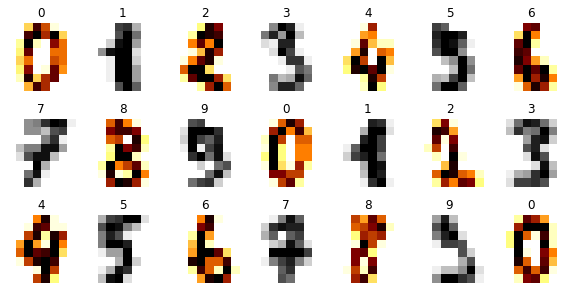

In [32]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [33]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [34]:
#пока не получается
# assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [35]:
print(knn.predict_proba(X_test).shape)
knn.predict_proba(X_test)

(360, 10)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
# не получилось
# train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [37]:
# не получилось
#assert train_acc == 1
#assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [38]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [39]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [40]:
PATH = "./data/"

In [41]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [42]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [43]:
## your code

male: 56114
female: 43886


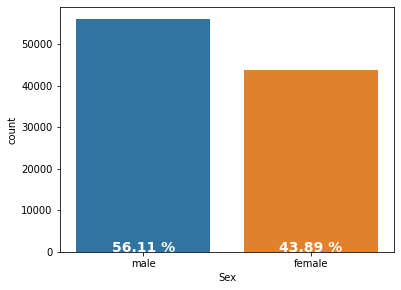

In [44]:
plt.figure(figsize=(6, 4.5)) 


ax = sns.countplot(x = 'Sex', data = data)
labels = (data['Sex'].value_counts()/100000*100)
print("male: " + str(data[data['Sex']=='male']['Sex'].count()))
print("female: " + str(data[data['Sex']!='male']['Sex'].count()))
for i, v in enumerate(labels):
    ax.text(i, v, str(round(v,2))+' %', horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

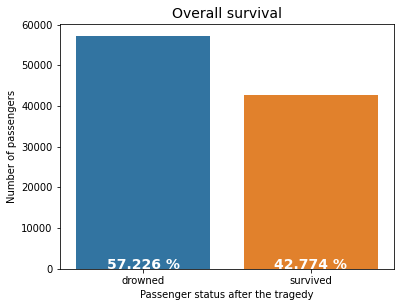

In [45]:
plt.figure(figsize=(6, 4.5)) 


ax = sns.countplot(x = 'Survived', data = data)


plt.xticks( np.arange(2), ['drowned', 'survived'] )

plt.title('Overall survival',fontsize= 14)

plt.xlabel('Passenger status after the tragedy')

plt.ylabel('Number of passengers')


labels = (data['Survived'].value_counts()/100000*100)

for i, v in enumerate(labels):
    ax.text(i, v, str(v)+' %', horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

% of women survived:  0.7115253155903933
% of men survived:    0.20579534519014864


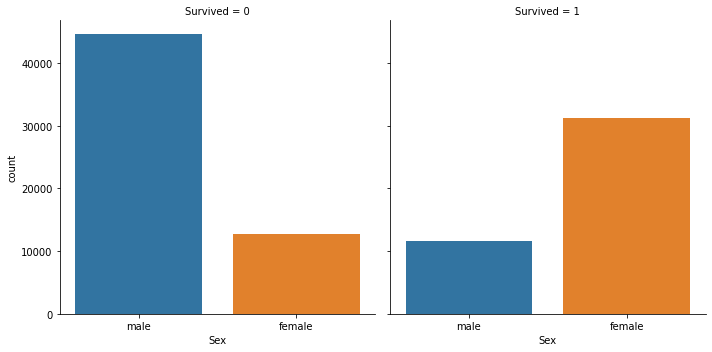

In [46]:
data.groupby(['Survived','Sex'])['Survived'].count()
sns.catplot(x='Sex', col='Survived', kind='count', data=data)
for i, v in enumerate(labels):
    ax.text(i, v-40, str(v)+' %', horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')
print("% of women survived: " , data[data.Sex == 'female'].Survived.sum()/data[data.Sex == 'female'].Survived.count())
print("% of men survived:   " , data[data.Sex == 'male'].Survived.sum()/data[data.Sex == 'male'].Survived.count())

< your thoughts >На борту было больше мужчин: 56%, всего выжило 43% пассажиров, при этом выжило 71% женщин и 20.5% мужчин

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [47]:
## your code

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,count,mean,std,min,25%,50%,75%,max
Age,96708.0,38.355472,18.313556,0.08,25.0,39.0,53.0,87.0


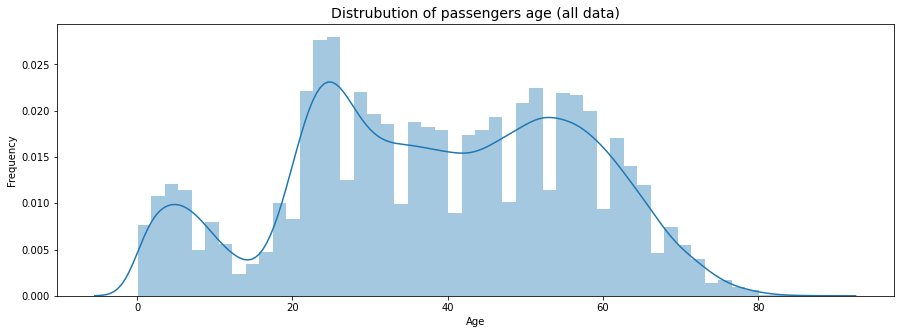

In [48]:
plt.figure(figsize=(15, 5))
sns.distplot(data["Age"], label = 'all')
plt.title('Distrubution of passengers age (all data)',fontsize= 14)
plt.xlabel('Age')
plt.ylabel('Frequency')
age_distr = pd.DataFrame(data['Age'].describe())
# Transpose index and columns.
age_distr.transpose()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


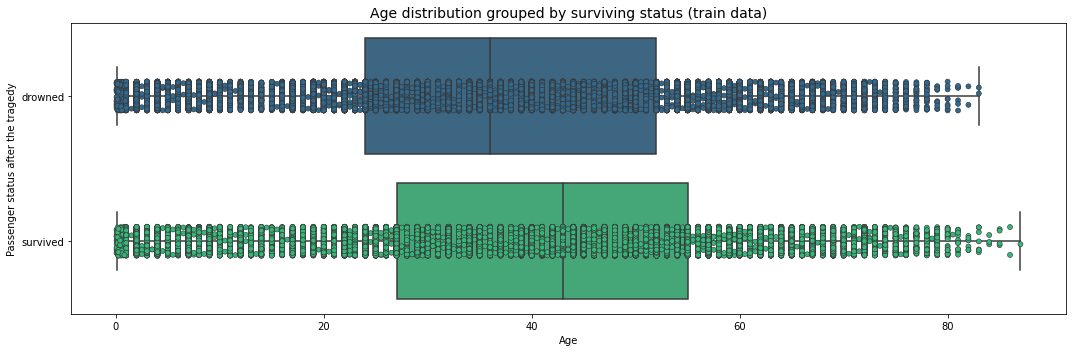

In [49]:
plt.figure(figsize=(15, 5))

# Draw a box plot to show Age distributions with respect to survival status.
sns.boxplot(y = 'Survived', x = 'Age', data =data,
     palette="viridis", fliersize = 0, orient = 'h')

# Add a scatterplot for each category.
sns.stripplot(y = 'Survived', x = 'Age', data =data,
     linewidth = 0.6, palette="viridis", orient = 'h')

plt.yticks( np.arange(2), ['drowned', 'survived'])
plt.title('Age distribution grouped by surviving status (train data)',fontsize= 14)
plt.ylabel('Passenger status after the tragedy')
plt.tight_layout()
pd.DataFrame(data.groupby('Survived')['Age'].describe())

< your thoughts >Средний возраст выживших (40.5) пассажиров выше, чем не у выживших (36.7)

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [50]:
## your code

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


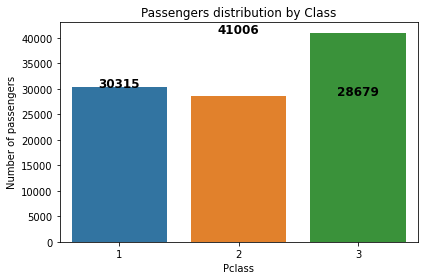

In [51]:
ax = sns.countplot(data['Pclass'])
labels = (data['Pclass'].value_counts(sort = False))
for i, v in enumerate(labels):
    ax.text(i, v+2, str(v), horizontalalignment = 'center', size = 12, color = 'black', fontweight = 'bold')

plt.title('Passengers distribution by Class')
plt.ylabel('Number of passengers')
plt.tight_layout()

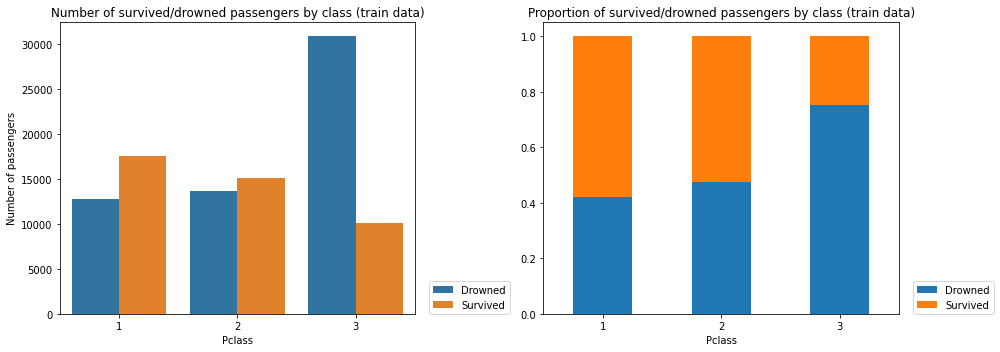

In [52]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(121)
sns.countplot(x = 'Pclass', hue = 'Survived', data = data, ax = ax1)
plt.title('Number of survived/drowned passengers by class (train data)')
plt.ylabel('Number of passengers')
plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
_ = plt.xticks(rotation=False)

ax2 = fig.add_subplot(122)
d = data.groupby('Pclass')['Survived'].value_counts(normalize = True).unstack()
d.plot(kind='bar', stacked='True', ax = ax2)
plt.title('Proportion of survived/drowned passengers by class (train data)')
plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
_ = plt.xticks(rotation=False)

plt.tight_layout()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


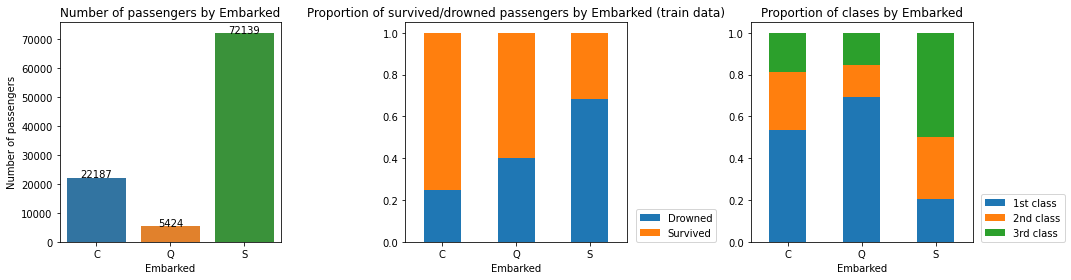

In [53]:
fig = plt.figure(figsize = (15,4))

ax1 = fig.add_subplot(131)
ax = sns.countplot(data['Embarked'], order = ['C', 'Q', 'S'], ax = ax1)
plt.title('Number of passengers by Embarked')
plt.ylabel('Number of passengers')

# calculate passengers for each category
labels = (data['Embarked'].value_counts())
labels = labels.sort_index()
# add result numbers on barchart
for i, v in enumerate(labels):
    ax.text(i, v+10, str(v), horizontalalignment = 'center', size = 10, color = 'black')
    

ax2 = fig.add_subplot(132)
surv_by_emb = data.groupby('Embarked')['Survived'].value_counts(normalize = True)
surv_by_emb = surv_by_emb.unstack().sort_index()
surv_by_emb.plot(kind='bar', stacked='True', ax = ax2)
plt.title('Proportion of survived/drowned passengers by Embarked (train data)')
plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
_ = plt.xticks(rotation=False)


ax3 = fig.add_subplot(133)
class_by_emb = data.groupby('Embarked')['Pclass'].value_counts(normalize = True)
class_by_emb = class_by_emb.unstack().sort_index()
class_by_emb.plot(kind='bar', stacked='True', ax = ax3)
plt.legend(('1st class', '2nd class', '3rd class'), loc=(1.04,0))
plt.title('Proportion of clases by Embarked')
_ = plt.xticks(rotation=False)

plt.tight_layout()

< your thoughts >Выжило больше пассажиров 1 и 2-го класса. Выжило больше пассажиров, порт посадки которых "С" и "Q"

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [54]:
## your code

In [55]:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100,2)))

Survived - 0.0%
Pclass - 0.0%
Name - 0.0%
Sex - 0.0%
Age - 3.29%
SibSp - 0.0%
Parch - 0.0%
Ticket - 4.62%
Fare - 0.13%
Cabin - 67.87%
Embarked - 0.25%


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages? 

< your thoughts >Можно удалить строки с недостающими данными, а можно заполнить средними значениями (Age, Fare), можно заполнить более часто встречающимся значением (Embarked) в некоторые столбцы можно добавить отдельное специальное значение для дальнейшего анализа (Ticket, Cabin)

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [56]:
## your code

<AxesSubplot:ylabel='PassengerId'>

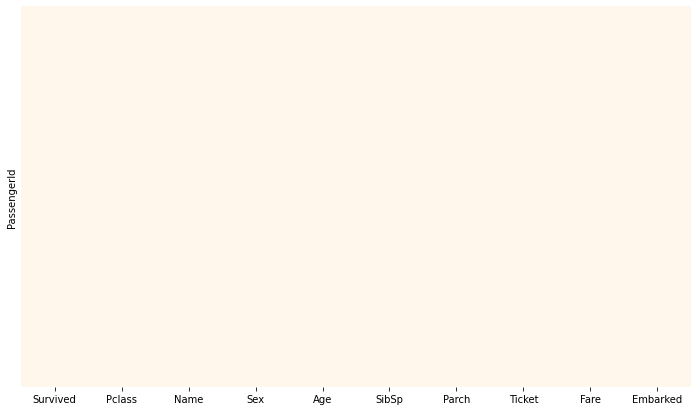

In [57]:
# 1.4. Заполнение Age, Ticket, Fare, Embarked, Удаление Cabin
def input_Age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 45
        elif Pclass == 2:
            return 39
        else:
            return 33
    return Age
data['Age'] = data[['Age','Pclass']].apply(input_Age,axis=1)
data['Ticket'] = data['Ticket'].fillna('000000')
f1 = round(data[data['Pclass']==1]['Fare'].mean(),2)
f2 = round(data[data['Pclass']==2]['Fare'].mean(),2)
f3 = round(data[data['Pclass']==3]['Fare'].mean(),2)

def input_Fare(cols, f1, f2, f3):
    Fare = cols[0]
    Pclass = cols[1]
    if pd.isnull(Fare):
        if Pclass == 1:
            return f1
        elif Pclass == 2:
            return f2
        else:
            return f3
    return Fare
data['Fare'] = data[['Fare','Pclass']].apply(input_Fare,axis=1, args=[f1,f2,f3])

def input_Embarked(col):
    Em = col[0]
    if pd.isnull(Em):
        return 'S'
    return Em
data['Embarked'] = data[['Embarked','Pclass']].apply(input_Embarked,axis=1)
data.drop('Cabin',axis=1,inplace=True)
# Проверка
plt.figure(figsize=(12,7))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='OrRd')

In [58]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,45.00,2,0,209245,27.14,S
1,0,3,"Bryan, Drew",male,33.00,0,0,27323,13.35,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,S


In [59]:
data['Sex_num'] = data.Sex.map({'male':0, 'female':1})

In [60]:
data['Embarked_num'] = data.Embarked.map({'C':0, 'Q':1, 'S':2})

In [61]:
feature_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_num', 'Embarked_num']
X = data[feature_cols]
y = data.Survived

In [62]:
print(X.shape)
print(y.shape)

(100000, 7)
(100000,)


In [63]:
knn = KNeighborsClassifier(n_neighbors=3)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [65]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [66]:
y_pred = knn.predict(X_test)
N = len(y_pred)
accuracy = ((np.asarray(y_test) == y_pred).sum()) / N
TP = ((y_pred == 1) & (y_test == 1)).sum()
FP = ((y_pred == 1) & (y_test == 0)).sum()
precision = TP / (TP+FP)
print('accuracy ' + str(accuracy))
print('precision ' + str(precision))


accuracy 0.71135
precision 0.6578454332552693


In [67]:
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1000000000.0)

In [68]:
y_pred  = logreg.predict(X_test)

In [69]:
y_pred

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [70]:
accuracy = ((np.asarray(y_test) == y_pred).sum()) / N
TP = ((y_pred == 1) & (y_test == 1)).sum()
FP = ((y_pred == 1) & (y_test == 0)).sum()
precision = TP / (TP+FP)
print('accuracy ' + str(accuracy))
print('precision ' + str(precision))

accuracy 0.7687
precision 0.7161174221122484


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [71]:
## your code

In [72]:
X_train['Fare'] = np.log(X_train['Fare'])

In [73]:
X_test['Fare'] = np.log(X_test['Fare'])

In [74]:
X_train['Age'] = np.log(X_train['Age'])

In [75]:
X_test['Age'] = np.log(X_test['Age'])

In [76]:
logreg = LogisticRegression(C=1.0, max_iter=5000, tol=0.000000001, penalty='none')
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, penalty='none', tol=1e-09)

In [77]:
y_pred  = logreg.predict(X_test)

In [78]:
accuracy = ((np.asarray(y_test) == y_pred).sum()) / N
TP = ((y_pred == 1) & (y_test == 1)).sum()
FP = ((y_pred == 1) & (y_test == 0)).sum()
precision = TP / (TP+FP)
print('accuracy ' + str(accuracy))
print('precision ' + str(precision))

accuracy 0.76935
precision 0.7165805436980454


In [79]:
knn = KNeighborsClassifier(n_neighbors=1000, weights='distance')

In [80]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [81]:
N = len(y_pred)
accuracy = ((np.asarray(y_test) == y_pred).sum()) / N
TP = ((y_pred == 1) & (y_test == 1)).sum()
FP = ((y_pred == 1) & (y_test == 0)).sum()
precision = TP / (TP+FP)
print('accuracy ' + str(accuracy))
print('precision ' + str(precision))

accuracy 0.76015
precision 0.7154929577464789


In [82]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_num,Embarked_num
PassengerId,,,,,,,
75220,1,3.806662,1,2,4.179451,0,2
48955,1,4.094345,0,0,6.067105,1,1
44966,3,3.496508,0,0,2.980619,0,2
13568,3,3.555348,0,0,1.924249,0,2
92727,1,3.401197,0,0,3.014063,1,0


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

Получилась плохая точность прогноза 76% не дотягивает до оценки. Для увеличения точности скорее всего надо все признаки - категориальные разбить на колонки вместо числового выражения. Т.к. 3-й класс не может быть больше 1, так и женский пол 1 - не лучше мужского 0. Некорректно выражать числом категорию.
